# AD10 - Dask + Pandas

O objetivo desta atividade dirigida é discutirmos elementos da integração entre Dask e Pandas, e como o paralelismo pode ser configurado (através do tamanho das partições) e explorado.


In [ ]:
import os
import dask
import dask.dataframe as dd



# Obtenção dos arquivos com os dados

Vamos baixar os arquivos no formato `.csv` do dataset de vôos.

Vejamos que os dados estão em arquivos CSV diferentes.

In [ ]:
%%bash
wget -q https://www.inf.ufrgs.br/~schnorr/cd009/ad10/nycflights.tar.gz -O nycflights.tar.gz
tar xvfz nycflights.tar.gz
du -hs nycflights

nycflights/
nycflights/1996.parquet
nycflights/1993.parquet
nycflights/1995.parquet
nycflights/1991.parquet
nycflights/1992.parquet
nycflights/1998.parquet
nycflights/1994.parquet
nycflights/1999.parquet
nycflights/1997.parquet
nycflights/1990.parquet
25M	nycflights


# Lançar o cluster

In [ ]:
from dask.distributed import Client
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 12.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35229,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 12.68 GiB
Comm: tcp://127.0.0.1:33743,Total threads: 1
Dashboard: http://127.0.0.1:44321/status,Memory: 3.17 GiB
Nanny: tcp://127.0.0.1:44103,


# Ler os dados utilizando dask

Os dados estão separados em múltiplos arquivos, um por ano. Vamos usar tal separação para permitir a leitura em paralelo.

O bloco de código abaixo utiliza um padrão para procura dos arquivos. Assim, podemos listar todos os arquivos.

In [ ]:
files = os.path.join("nycflights/199*.parquet")
files

'nycflights/199*.parquet'

Vamos invocar `read_csv` do dask.dataframe.

In [ ]:
import dask.dataframe as dd

ddf = dd.read_parquet(
    files,
    parse_dates={"Date": [0, 1, 2]},
    blocksize=None
)
ddf

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Os dados não foram lidos ainda. O que aconteceu:
- Quantos arquivos casam com o padrão procurado (neste caso dez)
- Já criou um conjunto de tarefas para cada arquivo
- Leu o início dos arquivos CSV para saber o cabeçalho

### Lembrando da Avaliação Preguiçosa

Vamos visualizar a "receita" uma vez que já configuramos a leitura dos dados.

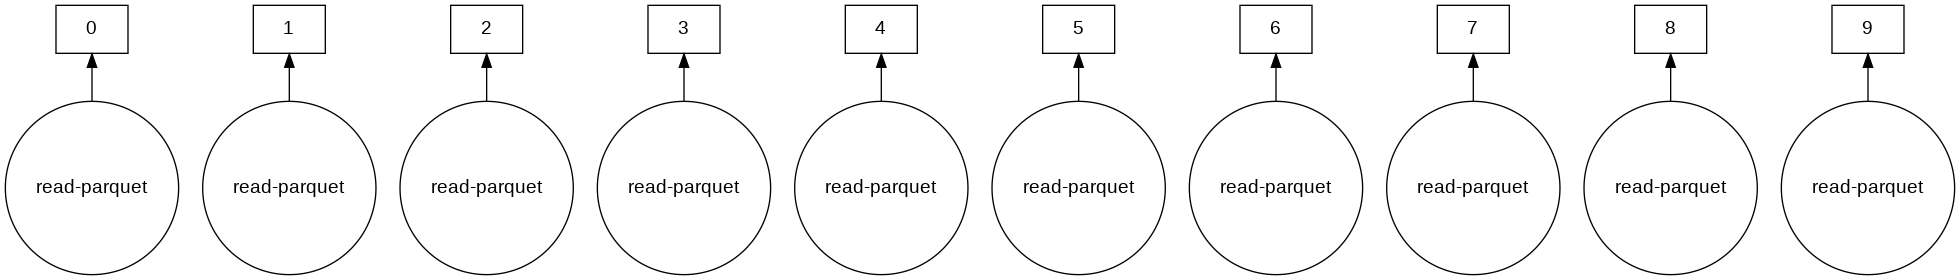

In [ ]:
ddf.visualize()

Poderíamos invocar explicitamente a leitura dos dados com o método `compute()`. Uma forma mais natural de uso é disparar o cálculo automaticamente, quando os dados são necessários para alguma função solicitada pelo programador. Por exemplo `len` e `head` disparam o cálculo implicitamente.

**Ao invocar funções como essas, o que acontece:**
1. Carregar efetivamente os dados (chamar vários `read_csv`)
2. Aplicar as operações invocadas em cada uma das partições
3. Combinar as respostas para dar a resposta final

Vamos carregar e contar a quantidade de linhas total:

In [ ]:
len(ddf)

2611892

Vamos ver o início dos dados:

In [ ]:
ddf.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


Ao ver o final, somos surpreendidos com um erro (faça o scroll da resposta até a parte mais inferior possível, onde teremos uma explicação - isso em geral é uma boa prática pois quando um erro acontece, devemos sempre ver a original inicial do erro, que frequentemente encontra-se no final da listagem de erros):

In [ ]:
ddf.tail()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999,12,27,1,1645.0,1645,1830.0,1901,UA,1753,...,205.0,-31.0,0.0,LGA,DEN,1619,7,13,0,0
269177,1999,12,28,2,1726.0,1645,1928.0,1901,UA,1753,...,214.0,27.0,41.0,LGA,DEN,1619,5,23,0,0
269178,1999,12,29,3,1646.0,1645,1846.0,1901,UA,1753,...,220.0,-15.0,1.0,LGA,DEN,1619,5,15,0,0
269179,1999,12,30,4,1651.0,1645,1908.0,1901,UA,1753,...,233.0,7.0,6.0,LGA,DEN,1619,5,19,0,0
269180,1999,12,31,5,1642.0,1645,1851.0,1901,UA,1753,...,232.0,-10.0,-3.0,LGA,DEN,1619,6,11,0,0


#### Caso do problema com arquivos CSV e `tail()`

```python
ddf.tail()

# ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

# +----------------+---------+----------+
# | Column         | Found   | Expected |
# +----------------+---------+----------+
# | CRSElapsedTime | float64 | int64    |
# | TailNum        | object  | float64  |
# +----------------+---------+----------+

# The following columns also raised exceptions on conversion:

# - TailNum
#   ValueError("could not convert string to float: 'N54711'")

# Usually this is due to dask's dtype inference failing, and
# *may* be fixed by specifying dtypes manually by adding:

# dtype={'CRSElapsedTime': 'float64',
#        'TailNum': 'object'}

# to the call to `read_csv`/`read_table`.

```

Por razões ligadas à avaliação preguiçosa, dask lê apenas o início dos arquivos (potencialmente lendo apenas um arquivo quando vários são fornecido) e a partir do que encontra infere os tipos das colunas (por isso podemos ver os tipos lá em cima, sem ler os dados).

O problema surge quando no final do arquivo temos dados cujo tipos não combinam com os dados encontrados no início, algo presente neste conjunto de dados.

Para resolver essa situação, devemos forçar os tipos através de parâmetros extras na leitura através de parâmetros tais como `dtype`, onde se fornece um dicionário Python que associa nome de colunas (strings) com tipos de dados, conforme no exemplo abaixo:

```{python}
dd.read_csv(
    files,
    parse_dates={"Date": [0, 1, 2]},
    dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
)
```

# Realizando cálculos com `dask.dataframe`

Para os dados que temos, vamos calcular o maior atraso de vôo.

Com `pandas`, nós teríamos que carregar cada arquivo para achar os máximos de cada ano, e então aplicar o `max` sobre os máximos locais.

In [ ]:
arquivos = os.listdir(os.path.join('nycflights'))
arquivos

['1999.parquet',
 '1998.parquet',
 '1991.parquet',
 '1996.parquet',
 '1994.parquet',
 '1997.parquet',
 '1990.parquet',
 '1993.parquet',
 '1995.parquet',
 '1992.parquet']

In [ ]:
%%time
import pandas as pd
arquivos = os.listdir(os.path.join('nycflights'))
maximos = [] # um vetor
for arquivo in arquivos:
    arq = os.path.join('nycflights', arquivo)
    df = pd.read_parquet(arq)
    maximos.append(df.DepDelay.max())
    
maximo_geral = max(maximos)
maximo_geral

CPU times: user 1.27 s, sys: 499 ms, total: 1.76 s
Wall time: 1.28 s


1435.0

Fazendo o mesmo com `dask.dataframe`, vejamos com a ausência do laço (que agora se tornou implícita, aplicando `max` para os dados de cada arquivo, depois calculando o máximo geral):

In [ ]:
%%time
result = ddf.DepDelay.max()
result.compute()

CPU times: user 54.2 ms, sys: 3.63 ms, total: 57.9 ms
Wall time: 204 ms


1435.0

**Nota importante:** Dask não mantém dados intermediários tal como o resultado da leitura dos dados dos arquivos. Isso implica que podemos trabalhar sobre arquivos que não caberiam em memória (caso fossem carregados todos ao mesmo tempo) mas, qualquer cálculo subsequente terá que refazer a leitura completa dos dados a cada vez.

Por exemplo, executar o código acima novamente não melhora o tempo.

Podemos, como sempre, ver o paralelismo através do grafo de tarefas:

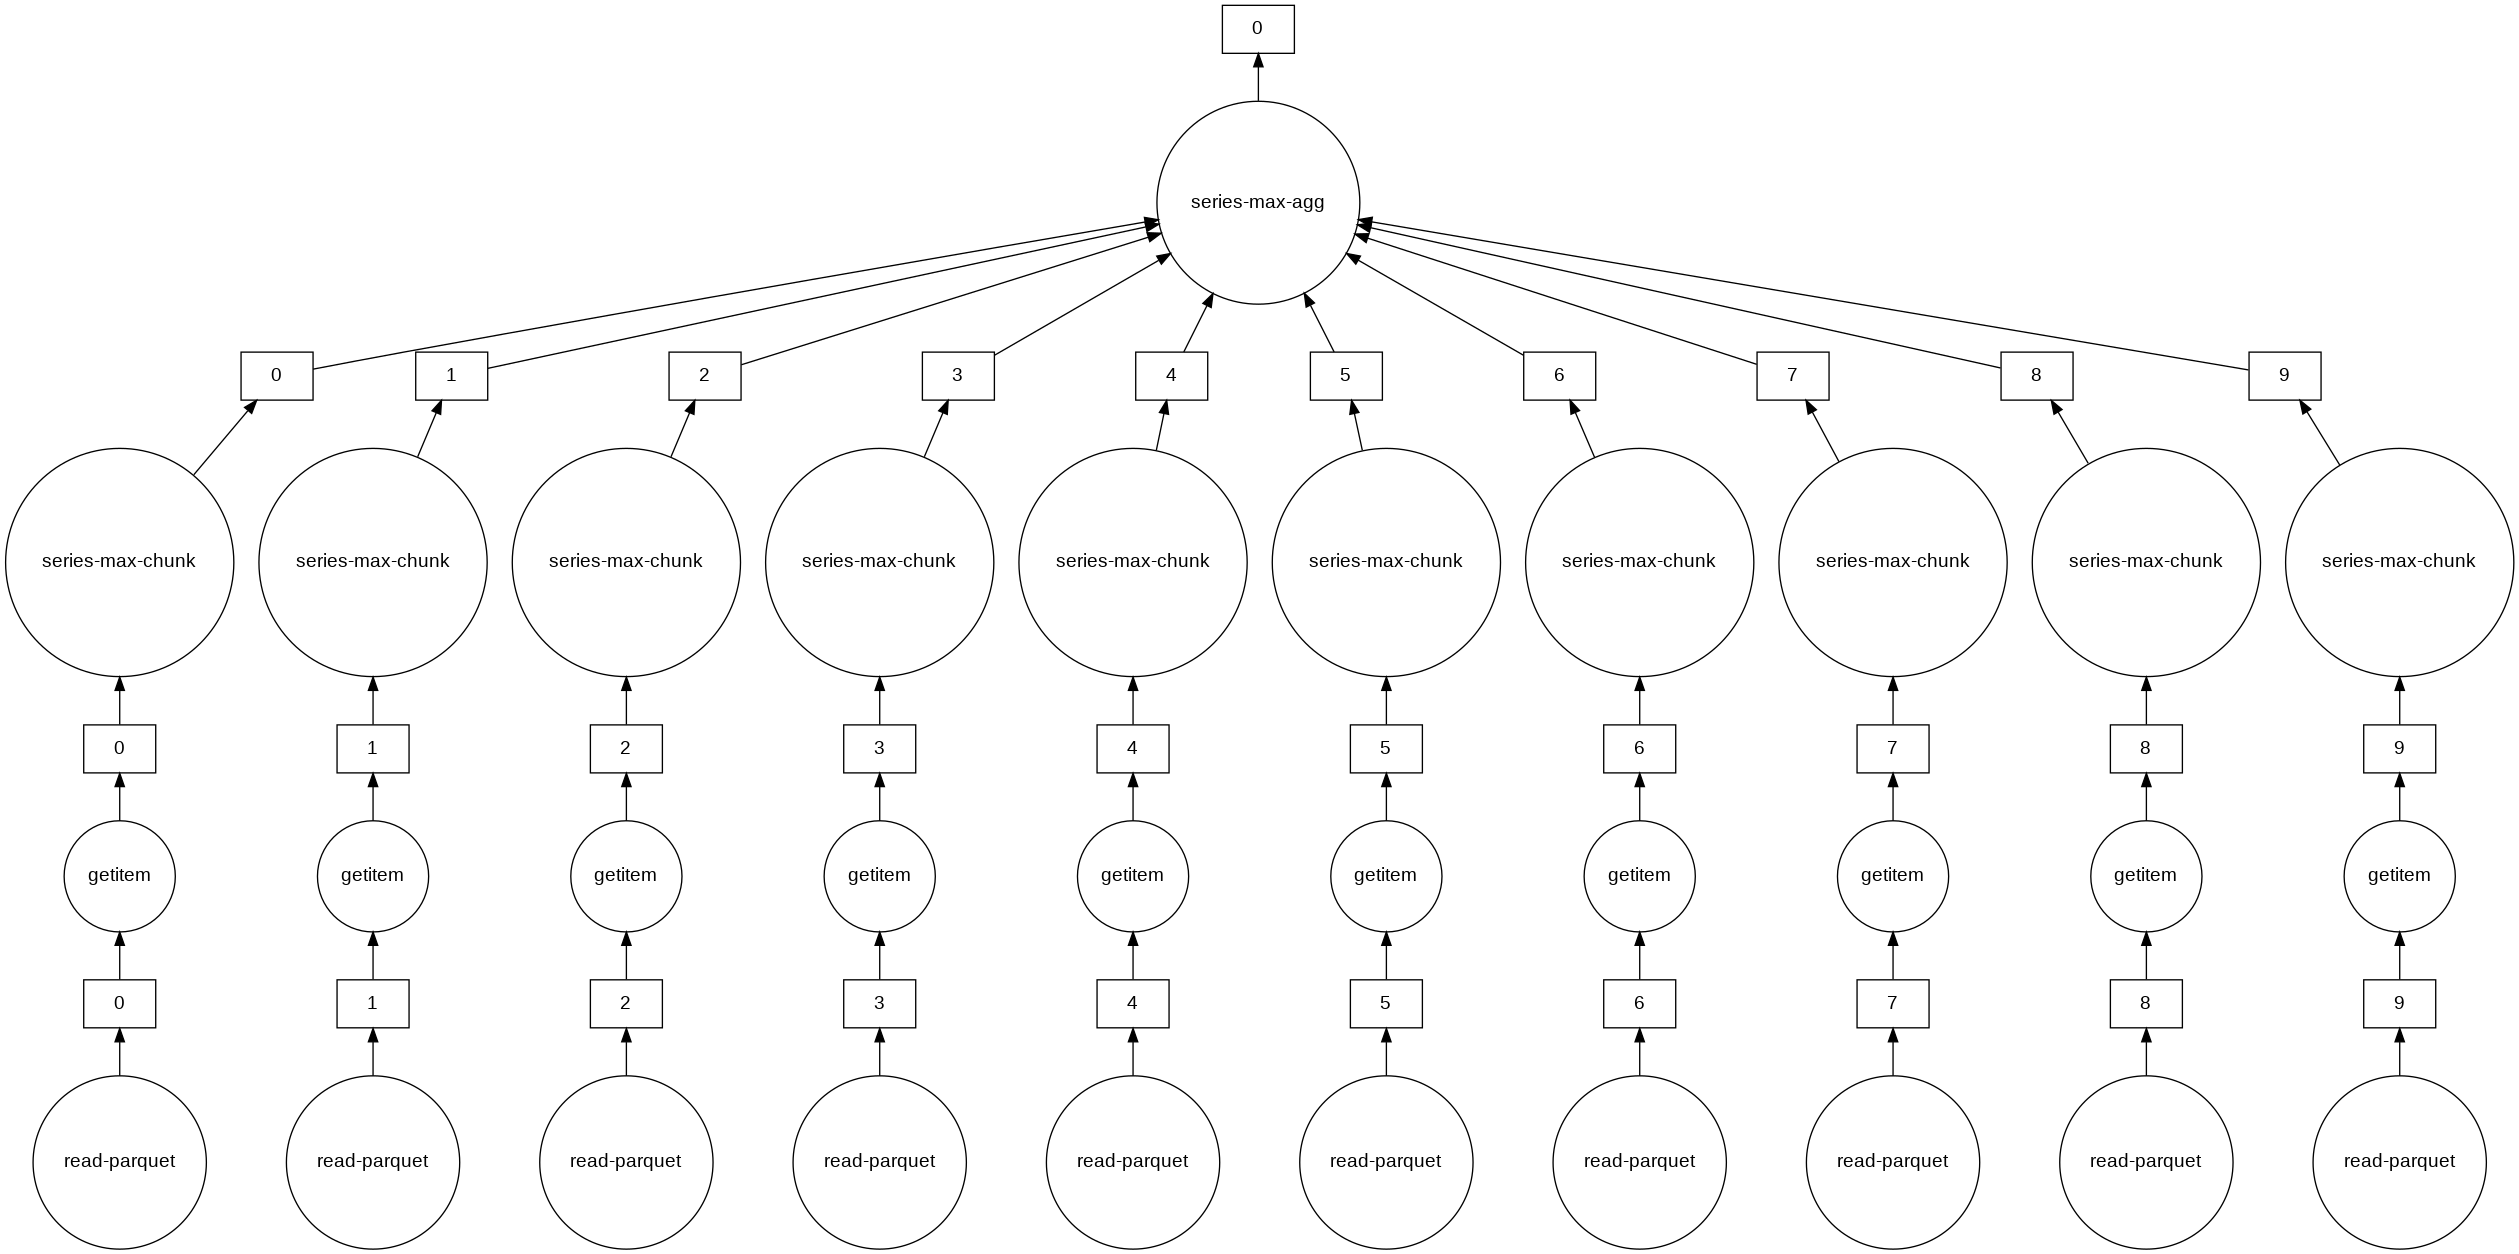

In [ ]:
result.visualize()

# Reparticionando os dados

Os dados originais estavam registrados em arquivos. Podemos vê-los através da quantidade de tarefas associadas à operação `read_csv`. Vejamos no final da saída do comando abaixo.

In [ ]:
ddf

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Em algumas situações, mesmo lendo os dados em paralelo, pode acontecer que manter em memória a integralidade do conteúdo dos arquivos seja impossível (pois os trabalhadores tem memória restrita). Isso é especialmente válido com DataFrame do Pandas pois seu autor disse que há um fator multiplicador do impacto em memória de um dado em disco (na ordem de 4-5 vezes).

Nestes cenários, após ler os arquivos, podemos reparticioná-los:
1. Para situações com pedaços **menores**, de maneira que o impacto em memória seja reduzido durante a execução do /workflow/ de tratamento e análise, ou quando deseja-se ter maior paralelismo.
2. Para pedaços **maiores**, quando a sobrecarga dos pedaços pequenos for demasiada grande.

Essa é a clássica discussão do tamanho do /chunk/ (lembrando do modelo PCAM, dos chunks do NumPy), aqui com esta nova terminologia, a "partição" dos dados (das tabelas pandas).

Para reparticipar, utilizamos o método `repartition`. Existem várias [formas de uso documentadas](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.repartition.html), vamos utilizar simplesmente um parâmetro que impõe a quantidade de partições que desejamos ter considerando todos os arquivos que estão marcados no grafo de tarefas para serem lidos. Vejamos novamente no final da saída do comando o aumento na quantidade de tarefas pois antes tínhamos 10 (uma leitura para cada arquivo, agora temos as tarefas de reparticionamento).

In [ ]:
ddf2 = ddf.repartition(20)
ddf2

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=20,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Vejamos as tarefas de reparticionamento no grafo de tarefas, percebendo que dados de arquivos diferentes não acabam misturados, portanto o reparticionamento é algo 100% paralelizável (de acordo com os argumentos empregados). Cada arquivo, que era uma partição, agora é separada em duas partições.

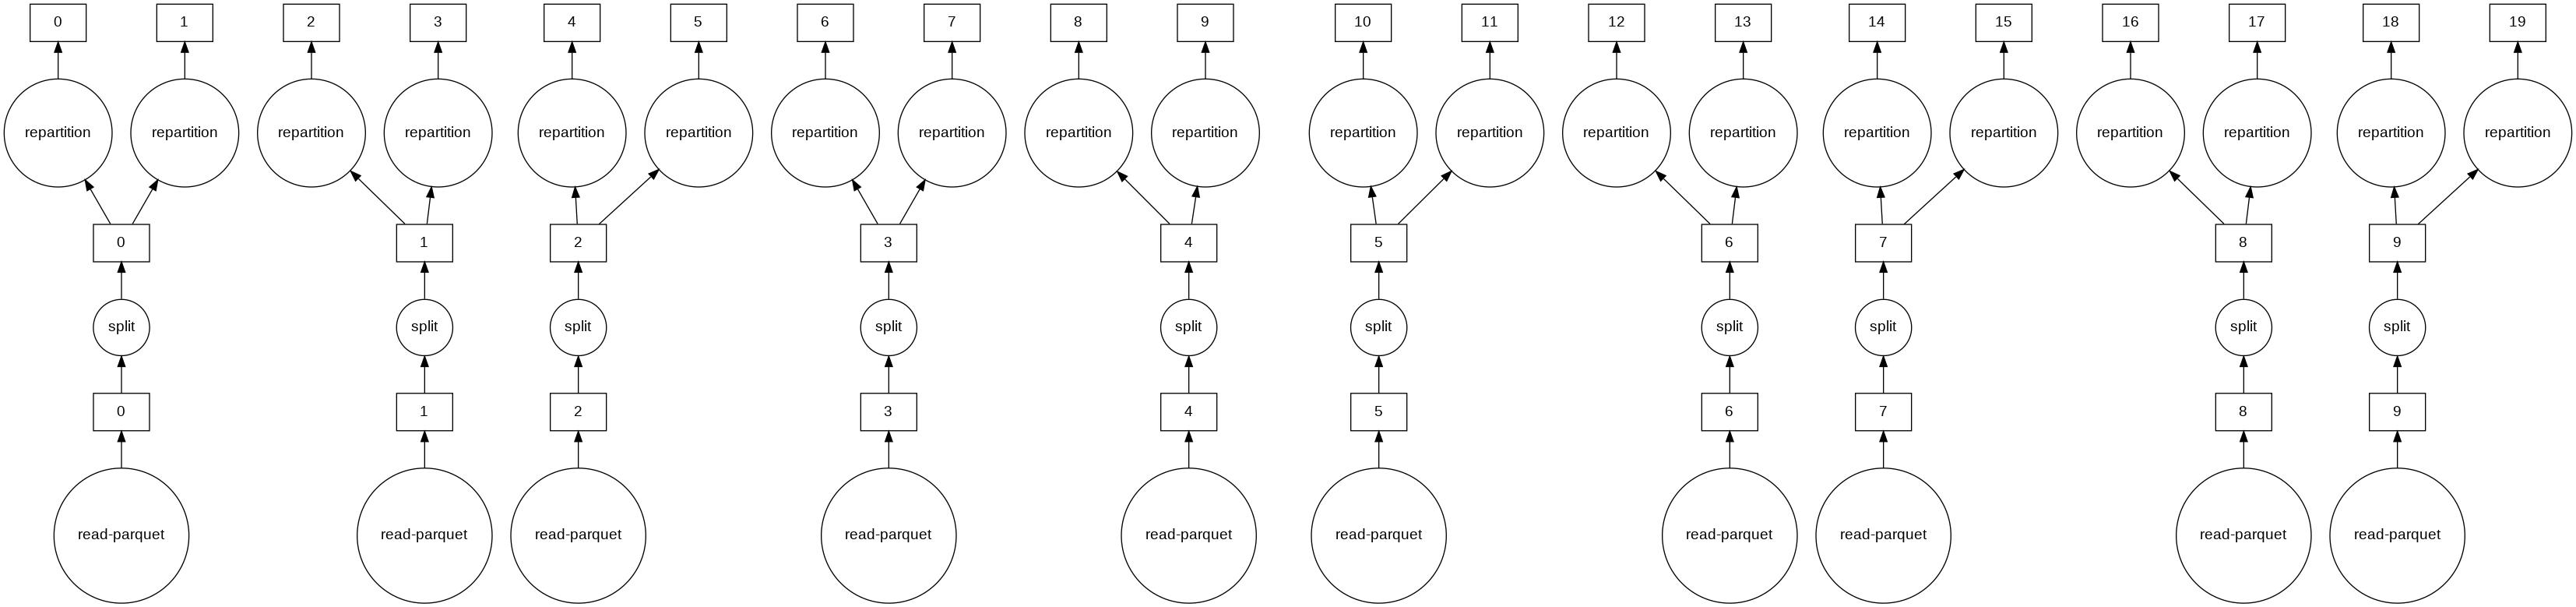

In [ ]:
ddf2.visualize()

# Estudos de caso

### 1. Quantos vôos não cancelados existiram?

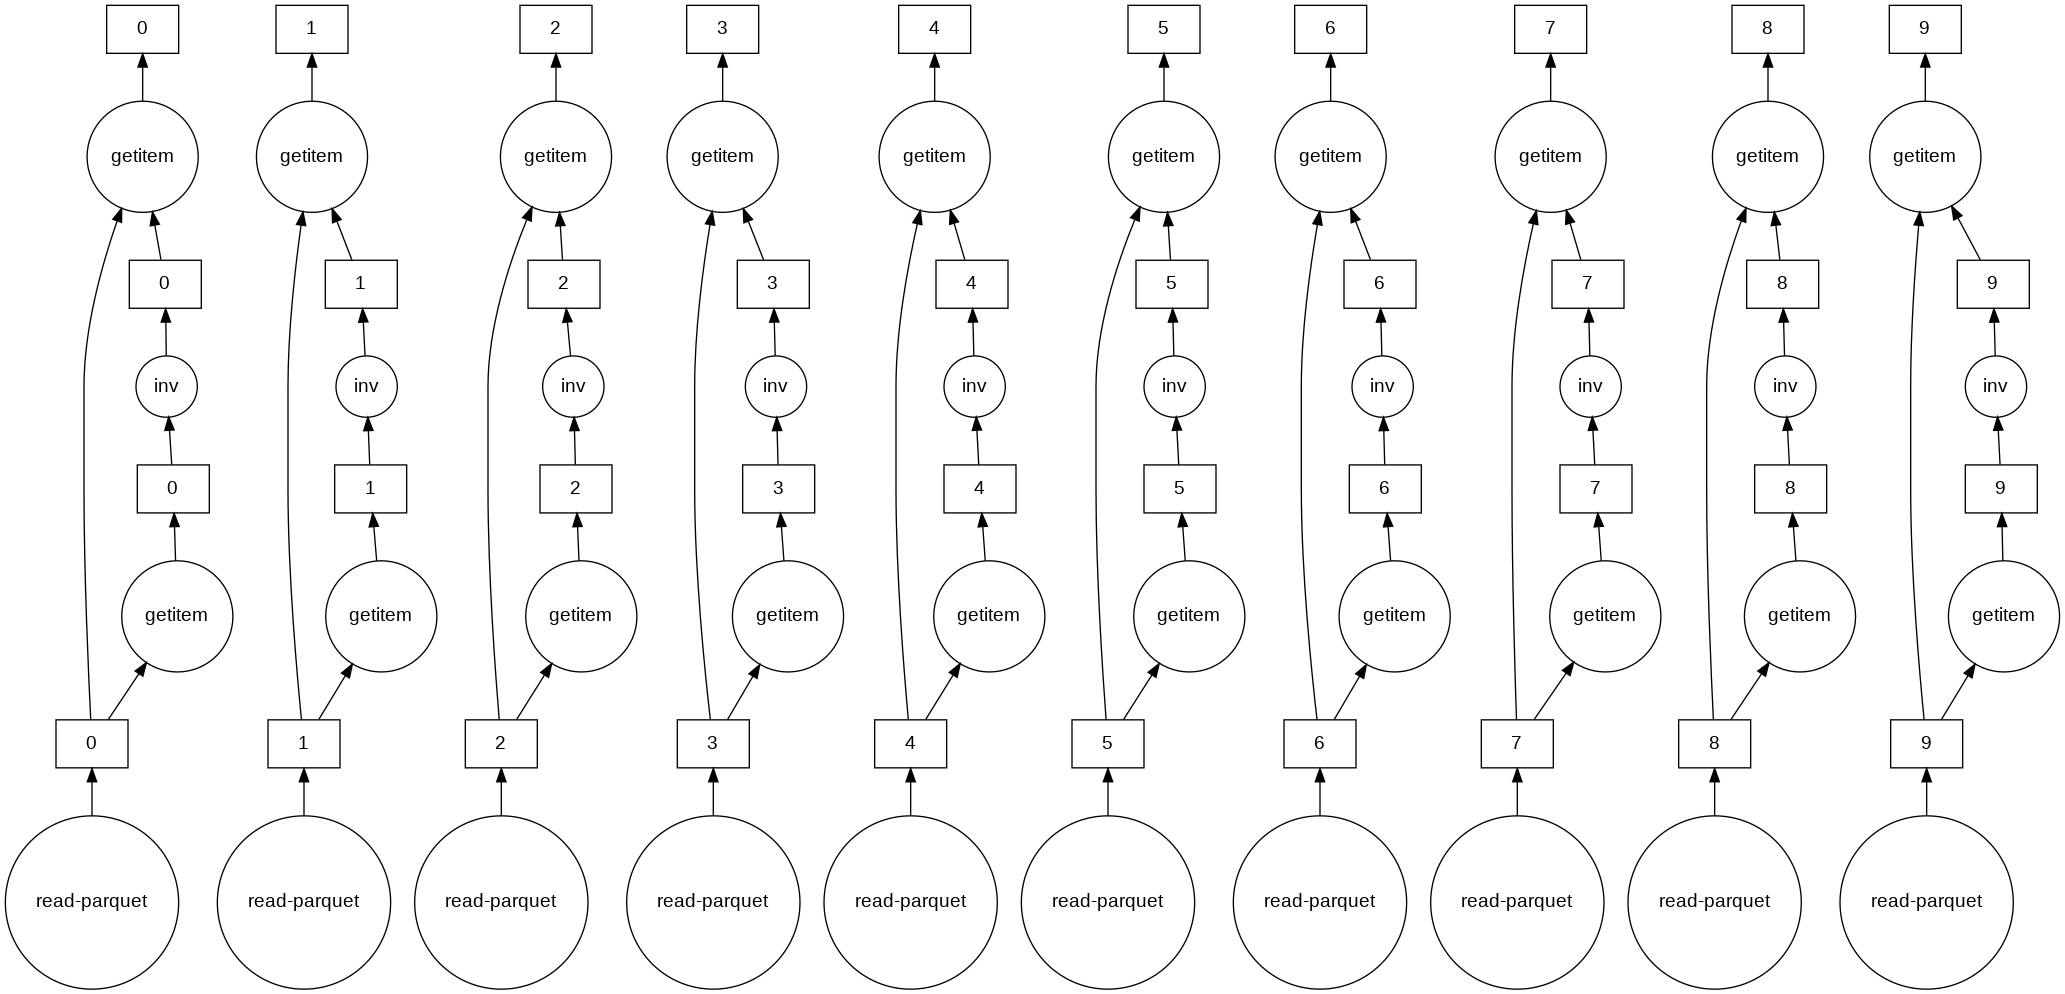

In [ ]:
resposta = ddf[~ddf.Cancelled]
dask.visualize(resposta, filename='graph.pdf')
resposta.visualize()

### 2. Quantos vôos existiram por aeroporto de origem?

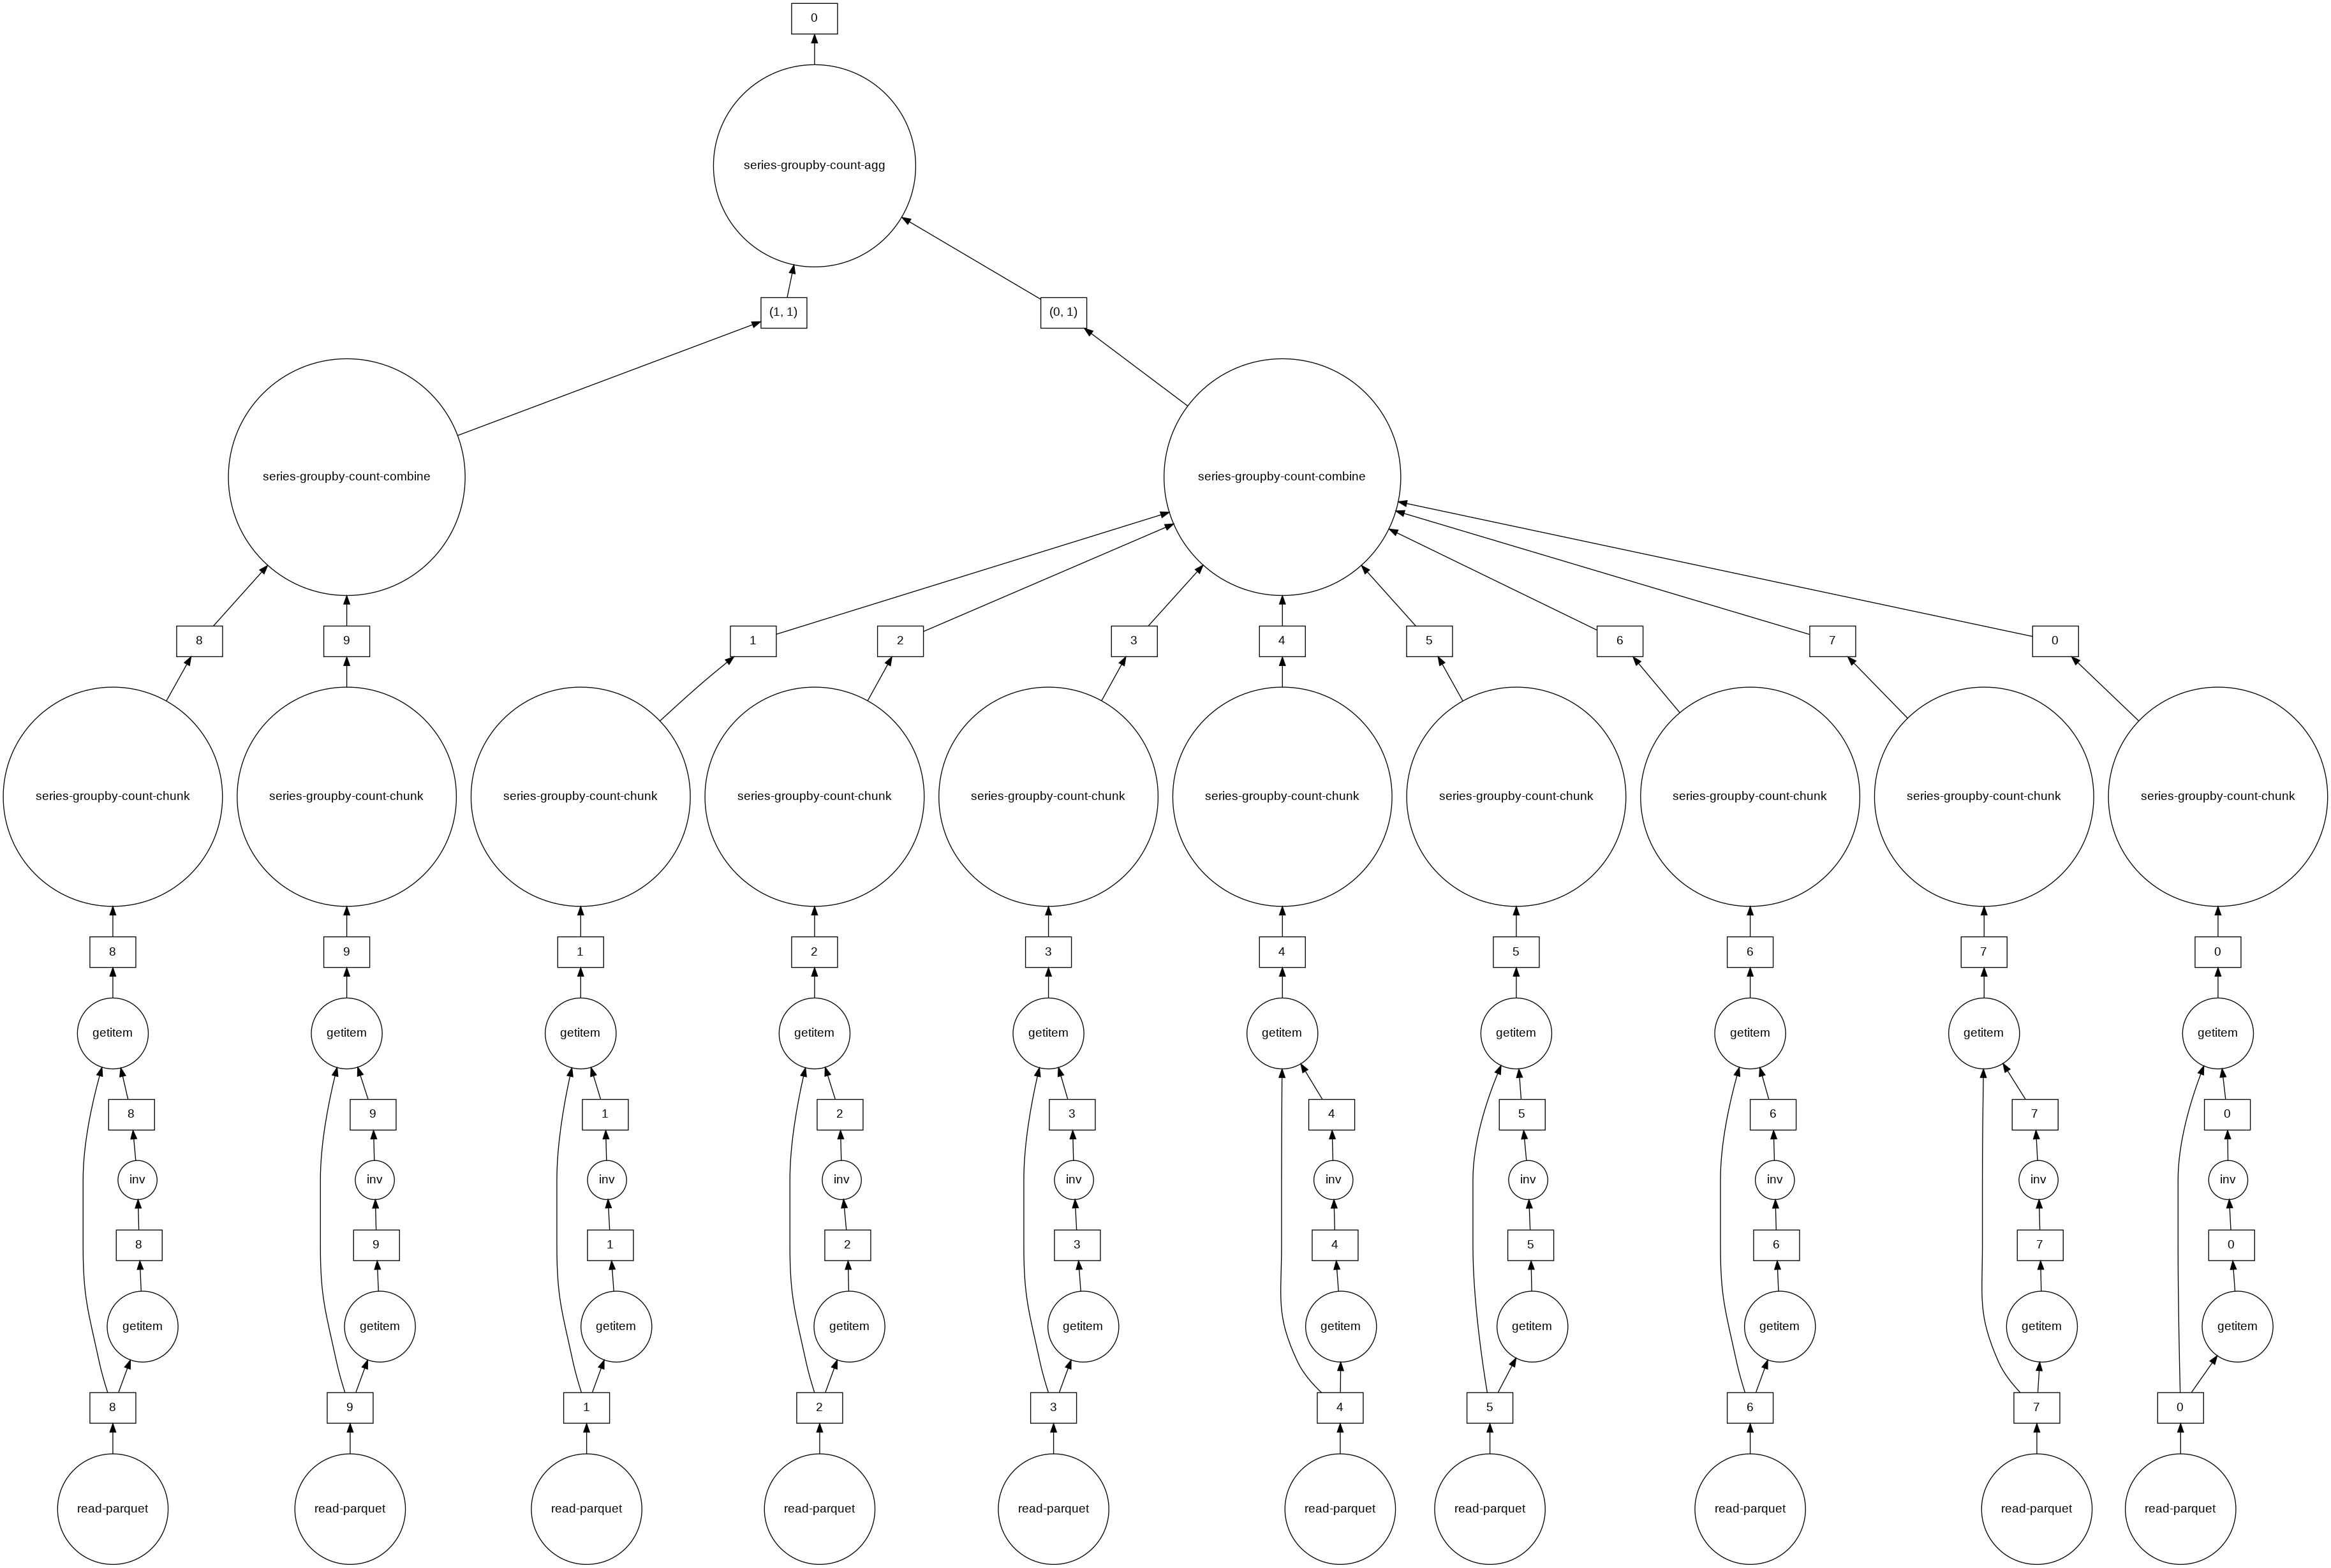

In [ ]:
resposta = ddf[~ddf.Cancelled].groupby("Origin").Origin.count()
dask.visualize(resposta, filename='graph.pdf')
resposta.visualize()

### 3. Qual foi o atraso médio de cada aeroporto de origem?

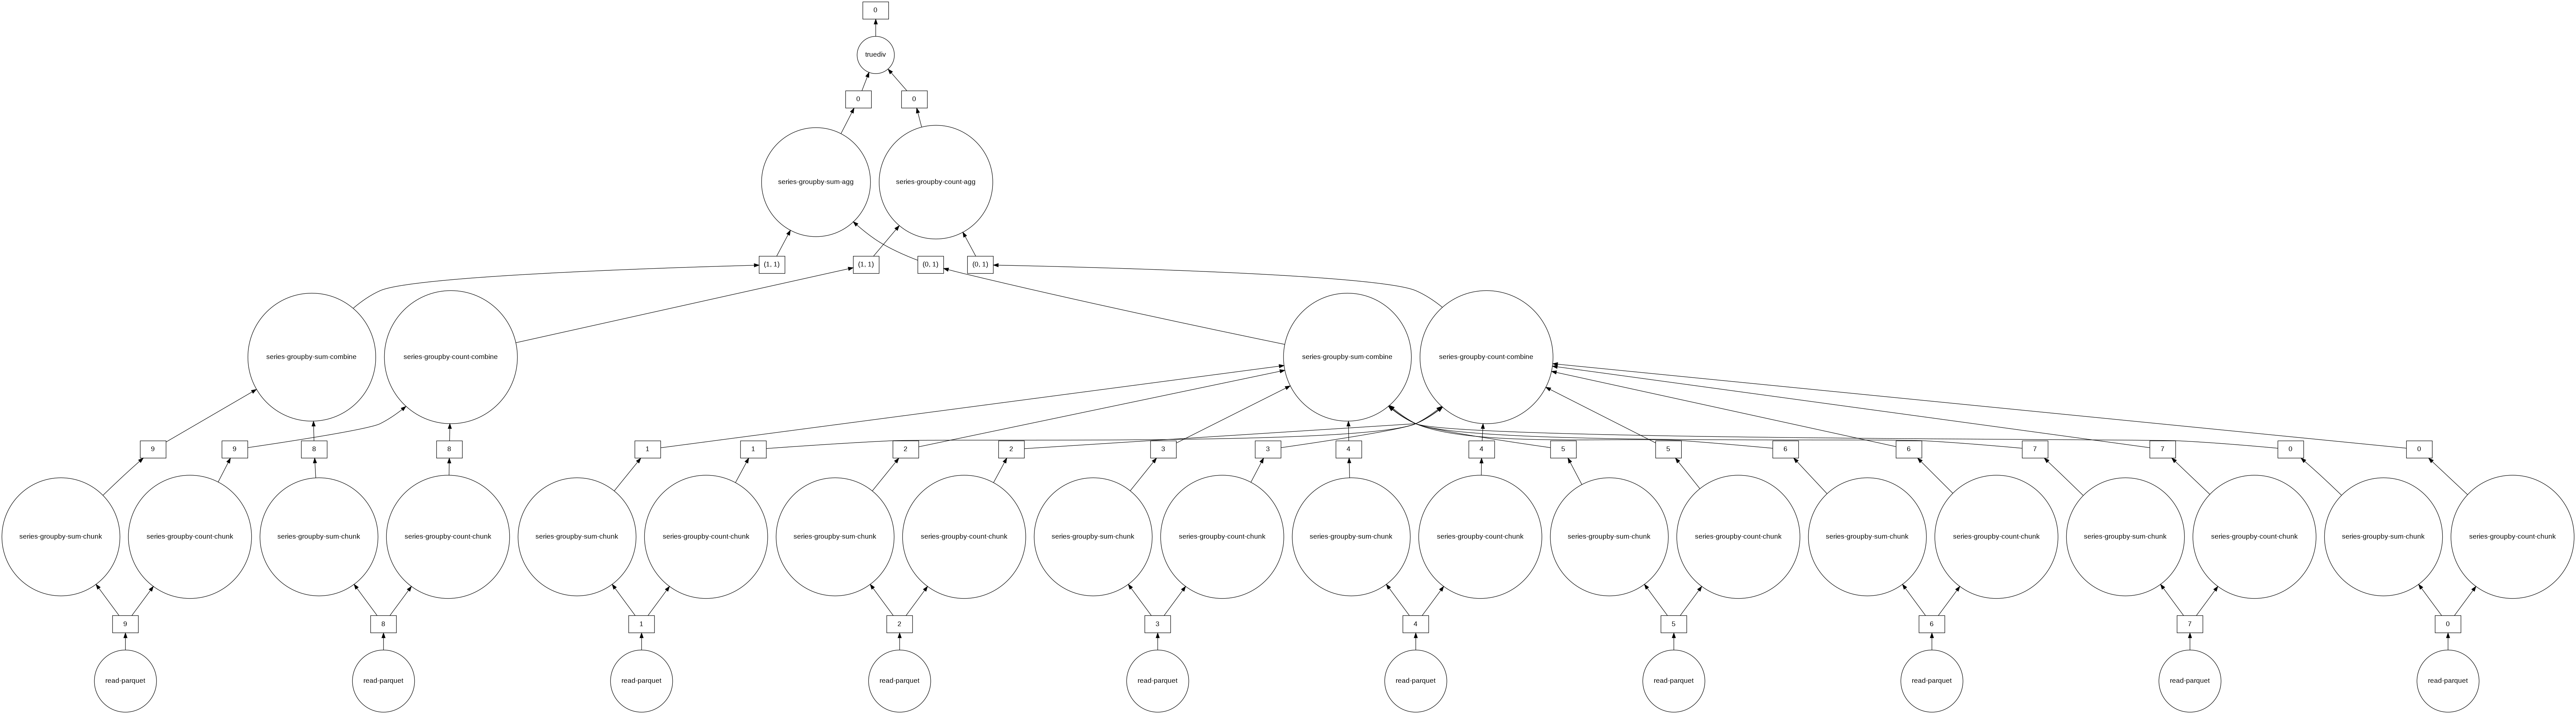

In [ ]:
resposta = ddf.groupby("Origin").DepDelay.mean()
dask.visualize(resposta, filename='graph.pdf')
resposta.visualize()

### 4. Qual dia da semana tem o maior atraso?

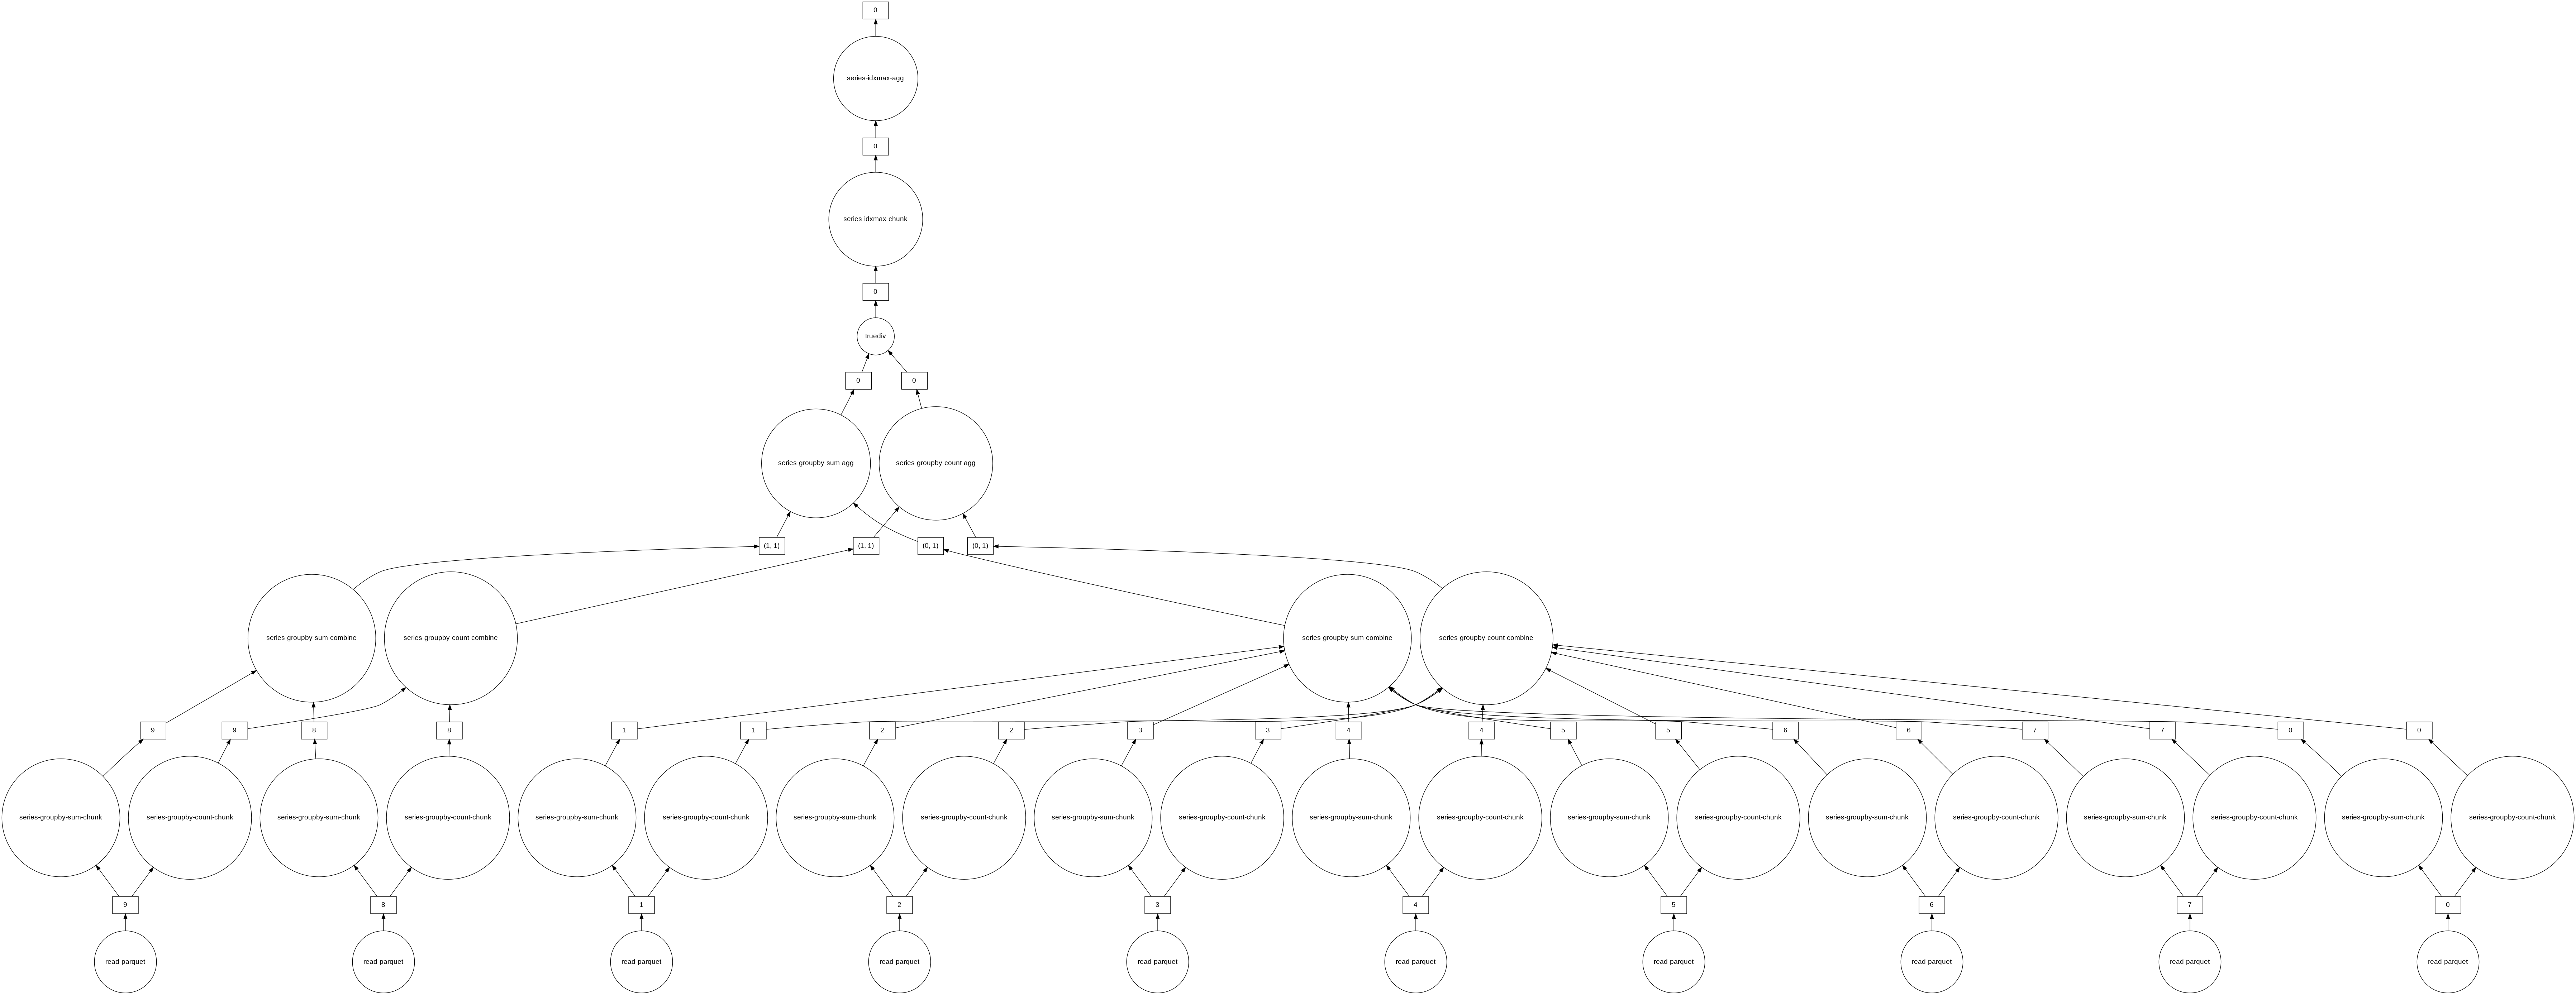

In [ ]:
resposta = ddf.groupby("DayOfWeek").DepDelay.mean().idxmax()
dask.visualize(resposta, filename='graph.pdf')
resposta.visualize()

# Compartilhamento de valores intermediários

Quando escrevemos um /workflow/ de tratamento de dado, existem situações onde repetimos as operações. Vejamos um exemplo disso:

In [ ]:
non_canceled = ddf[(ddf["Cancelled"] == 0)] # a operação que será repetida
mean_delay = non_canceled.DepDelay.mean()
std_delay = non_canceled.DepDelay.std()

CPU times: user 802 ms, sys: 122 ms, total: 924 ms
Wall time: 6.36 s


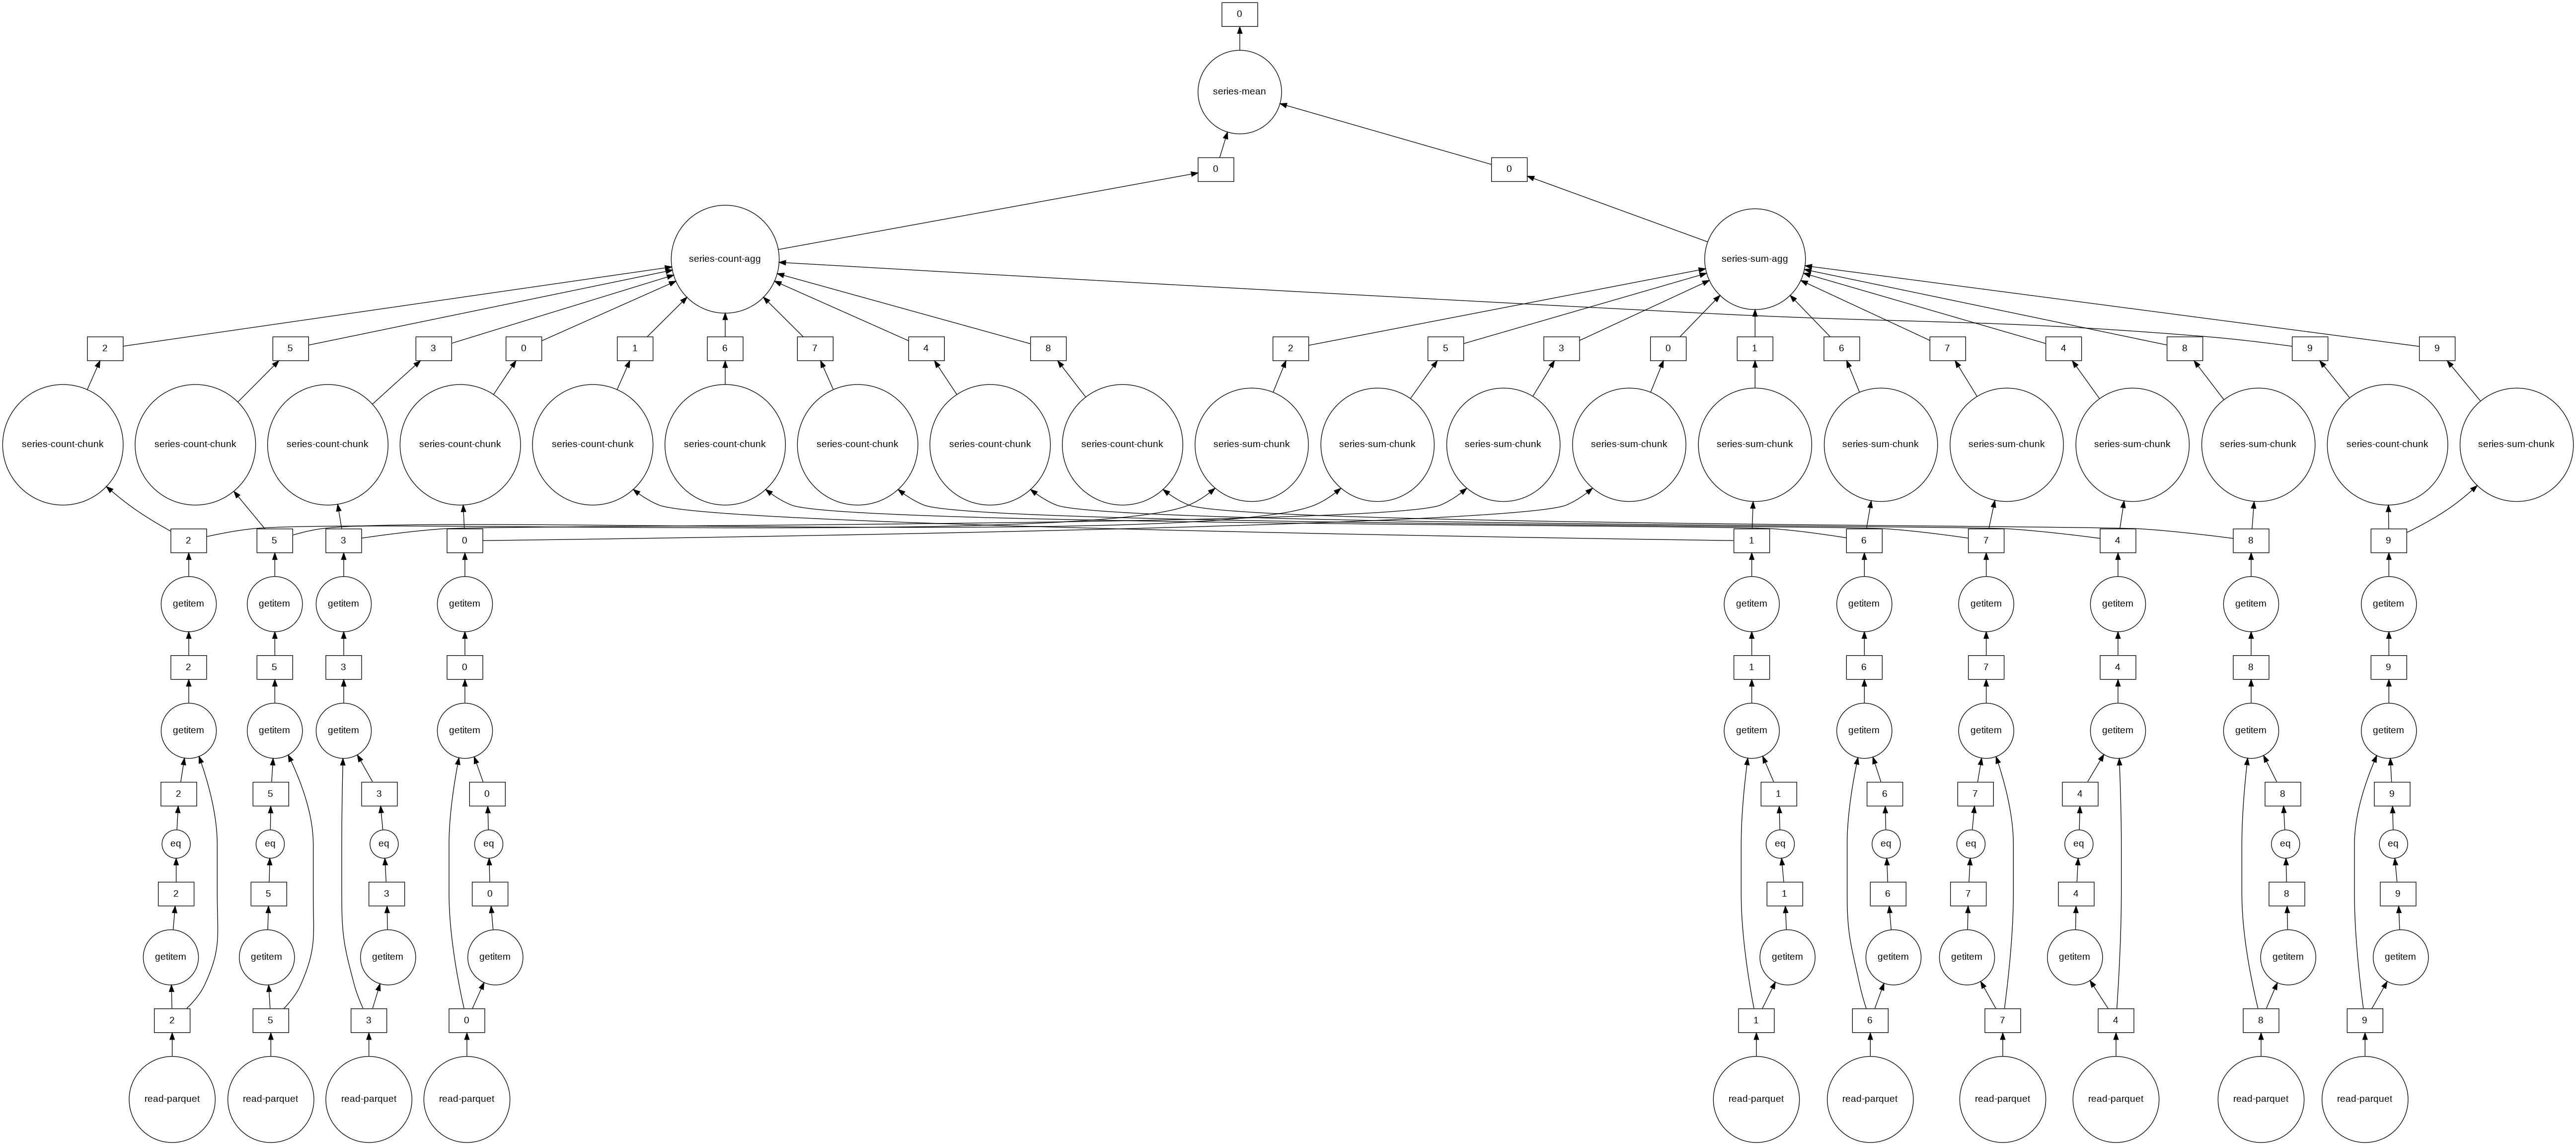

In [ ]:
%%time
mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()
mean_delay.visualize()

Nesta situações, é interessante empregar `dask.compute` ao invés do método `.compute()` associado ao objeto. O emprego de `dask.compute` torna a avaliação do grafo de tarefas mais sofisticado, pois ele detecta partes do grafo que são idênticas, juntando-as. Assim, podemos empregar da seguinte forma:

In [ ]:
%%time
dask.compute(mean_delay, std_delay)

CPU times: user 339 ms, sys: 53.9 ms, total: 393 ms
Wall time: 2.16 s


(9.206602541321965, 28.974539774551456)

Podemos também visualizar o grafo resultante:

In [ ]:
!apt-get install poppler-utils
!pip install pdf2image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.14 [154 kB]
Fetched 154 kB in 0s (877 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.14_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.14) ...
Setting up poppler-utils (0.62.0-2ubuntu2.14) ...
P

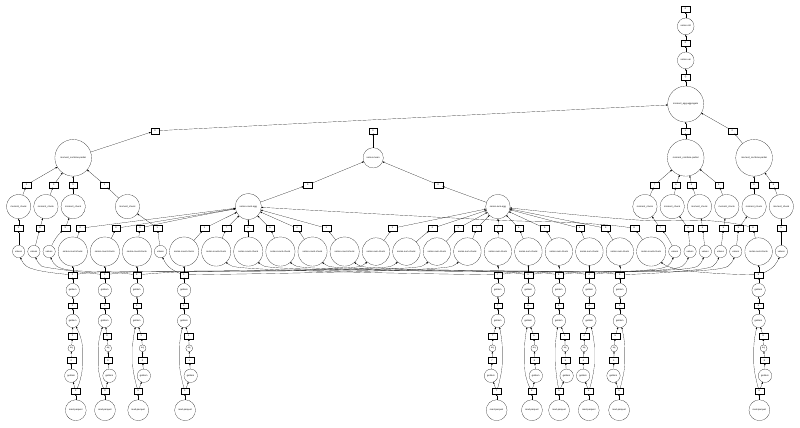

In [ ]:
dask.visualize(mean_delay, std_delay, filename='graph.pdf')
from pdf2image import convert_from_path, convert_from_bytes
from IPython.display import display, Image
images = convert_from_bytes(open('graph.pdf', 'rb').read(), size=800)
display(images[0])


# Persistência de dados em memória

Até o presente momento, os dados são sempre liberados uma vez utilizados e retornados ao usuário (neste caso o Jupyter Notebook). Quando se está trabalhando com um escalonador distribuído (no cluster), nós podemos /forçar/ que alguns dados permaneçam em memória após o cálculo, de maneira que execuções subsequentes reutilizem dados já calculados.

Vejamos uma execução sem persistência de dados em memória:

In [ ]:
nc = ddf[(ddf["Cancelled"] == 0)]
ddf_jfk = nc[(nc["Origin"] == "JFK")]

In [ ]:
%%time
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.sum().compute()

CPU times: user 709 ms, sys: 93.9 ms, total: 803 ms
Wall time: 5.72 s


4422520.0

Podemos perceber que os dados da estrutura `ddf_jfk` poderiam ser persistidos, fazendo que a segunda chamada ao método `compute()`, para calcular a soma, se beneficiasse dos dados já em memória. Para tornar isso possível, empregamos o método `.persist()` sobre os dados que desejamos manter em memória (atenção para os limites de memória).

In [ ]:
ddf_jfk = ddf_jfk.persist()  # marca a persistância, execução imediata

In [ ]:
%%time
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.sum().compute()

CPU times: user 142 ms, sys: 10.3 ms, total: 152 ms
Wall time: 260 ms


4422520.0

# Fechar o cliente e o cluster

In [ ]:
client.shutdown()